#**X-Ray Attenuation**

In this part of the experiment we are measurig x-ray absorption using two filters: Zr and Mo. The original dataset consists in one column for the measured angle and 3 columns of counts: without filter, with Zr filter and with Mo filter. The angle range is from θmin = 2.5̊ and θmax = 12̊ , Δt = 10s, Δθ = 0.1̊ , I = 1 mA and U = 35 kV. In the reading dataset part of the noteook it is going to be added the uncertainties.

The equipment software delivers the count column divided by Δt, so in the case of sets where Δt = 10s we have to multiply the count column by 5 and then add the influence of time in the uncertainty calculation: $σ(N) =  \sqrt(N) /Δt$.

The equipament uncertainty in θ is 0.05̊.


**X-Ray absorption:**

$N=N_oe^{-μx}$

$N$: Number of photons after the filter.

$N_o$: Number of photons before the filter.

μ: Attenuation coefficient.

$x$: Absorber thickness.

**Absorbance = $N_o/N$**

**Experiment tasks:**

*   Plot X-Ray absorbance vs Energy and its uncertainties.
*   To analyse the absorption edges for Zr and Mo  and comment the results comparing them to the expected ones.
*   Is it possibe to obtain the absorber thickness from the data? If so, determine the thickness of Zr and Mo.

**To obtain the plots:**

To calculate energy: $E = \frac{hc}{λ}$, where λ is obtained from Bragg equation $nλ=2dsin(θ)$. 

h = $4.14 × 10^{-15}$ eV s

n = 1

c = $3×10^8$ m/s

d = 0.282 nm (NaCl crystal parameter)

*  Propagate the uncertainties from θ to λ and then to energy.
*  Propagate the uncertainties from counts to absorbance.

**Absorption energy edges:**

**Mo:** 20.000 keV

**Zr:** 17.996 keV

**Importing libraries:**

In [10]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import linregress as lr
from scipy import odr
import plotly.express as px
import math

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Reading dataset and adding data uncertainties:** 


In [3]:
d = np.loadtxt('/content/drive/MyDrive/Raio X/Raio X/Dados/c3-sfiltro-mo-zr.txt')
df = pd.DataFrame(d, columns=['Angle', 'No filter', 'Mo', 'Zr'])
df['Sigma Angle'] = 0.05
df['Sigma No filter'] = np.sqrt(df['No filter']*10)/10
df['Sigma Mo'] = np.sqrt(df['Mo']*10)/10
df['Sigma Zr'] = np.sqrt(df['Zr']*10)/10
df.head()

,Angle,No filter,Mo,Zr,Sigma Angle,Sigma No filter,Sigma Mo,Sigma Zr
0,2.5,6.6,5.0,13.8,0.05,0.812404,0.707107,1.174734
1,2.6,7.8,5.3,15.4,0.05,0.883176,0.728011,1.240967
2,2.7,7.6,5.7,15.1,0.05,0.871780,0.754983,1.228821
3,2.8,7.4,7.4,15.6,0.05,0.860233,0.860233,1.249000
4,2.9,9.1,6.3,14.1,0.05,0.953939,0.793725,1.187434


**Adding the Energy and Absorbance columns with its uncertainties:**

In [4]:
# Planck constant:
h = 4.14*10**-15 # eV s

# c constant:
c = 3*10**8 #m/s

# Crystal constant:
d = 0.282*10**-9 #m

lambdaa = 2*d*np.sin(df['Angle']*np.pi/180)
df['Energy (keV)'] = ((h*c)/lambdaa)/1000
sigma_lambda = 2*d*np.cos(df['Angle']*np.pi/180)*df['Sigma Angle']
df['Sigma Energy (keV)'] = np.sqrt(((-(h*c)/lambdaa*1000)**2)*sigma_lambda**2)
df['Mo Absorbance'] = df['No filter']/df['Mo']
df['Zr Absorbance'] = df['No filter']/df['Zr']
df['Sigma Mo Absorb'] = np.sqrt(((1/df['Mo'])**2)*(df['Sigma No filter']**2) + (((-df['No filter']/(df['Mo']**2))**2)*(df['Sigma Mo']**2)))
df['Sigma Zr Absorb'] = np.sqrt(((1/df['Zr'])**2)*(df['Sigma No filter']**2) + (((-df['No filter']/(df['Zr']**2))**2)*(df['Sigma Zr']**2)))
df.head(20)


,Angle,No filter,Mo,Zr,Sigma Angle,Sigma No filter,Sigma Mo,Sigma Zr,Energy (keV),Sigma Energy (keV),Mo Absorbance,Zr Absorbance,Sigma Mo Absorb,Sigma Zr Absorb
0,2.5,6.6,5.0,13.8,0.05,0.812404,0.707107,1.174734,50.485066,0.001422,1.320000,0.478261,0.247483,0.071576
1,2.6,7.8,5.3,15.4,0.05,0.883176,0.728011,1.240967,48.544590,0.001368,1.471698,0.506494,0.261981,0.070390
2,2.7,7.6,5.7,15.1,0.05,0.871780,0.754983,1.228821,46.747900,0.001317,1.333333,0.503311,0.233626,0.070787
3,2.8,7.4,7.4,15.6,0.05,0.860233,0.860233,1.249000,45.079591,0.001270,1.000000,0.474359,0.164399,0.066957
4,2.9,9.1,6.3,14.1,0.05,0.953939,0.793725,1.187434,43.526382,0.001226,1.444444,0.645390,0.236739,0.086783
5,3.0,9.1,5.7,16.4,0.05,0.953939,0.754983,1.280625,42.076764,0.001185,1.596491,0.554878,0.269674,0.072531
6,3.1,9.5,6.8,16.7,0.05,0.974679,0.824621,1.292285,40.720710,0.001147,1.397059,0.568862,0.221918,0.073103
7,3.2,9.0,5.6,18.2,0.05,0.948683,0.748331,1.349074,39.449450,0.001111,1.607143,0.494505,0.273537,0.063723
8,3.3,9.1,6.2,17.6,0.05,0.953939,0.787401,1.326650,38.255275,0.001077,1.467742,0.517045,0.241701,0.066759
9,3.4,22.5,6.0,24.4,0.05,1.500000,0.774597,1.562050,37.131383,0.001045,3.750000,0.922131,0.544862,0.085230


**Dropping experimental artefacts where energy is higher than 35 keV:**

In [6]:
df = df.drop(labels=range(0,12), axis=0)

**Plotting:**

**Count vs Angle:**

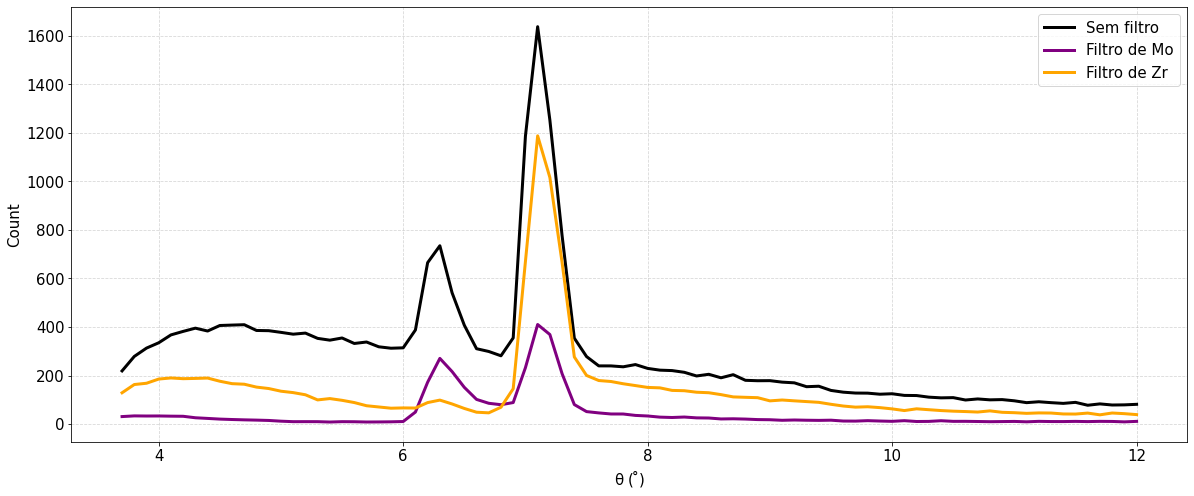

In [26]:
plt.figure(figsize=(20,8))
plt.plot(df['Angle'], df['No filter'], color='black', label='Sem filtro', lw=3)
plt.plot(df['Angle'], df['Mo'], color='purple', label='Filtro de Mo', lw=3)
plt.plot(df['Angle'], df['Zr'], color='orange', label='Filtro de Zr', lw=3)
plt.xlabel('θ ( $\ocirc$)', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(ls='dashed', alpha=0.5)

**Absorbance:**

<Figure size 900x600 with 0 Axes>

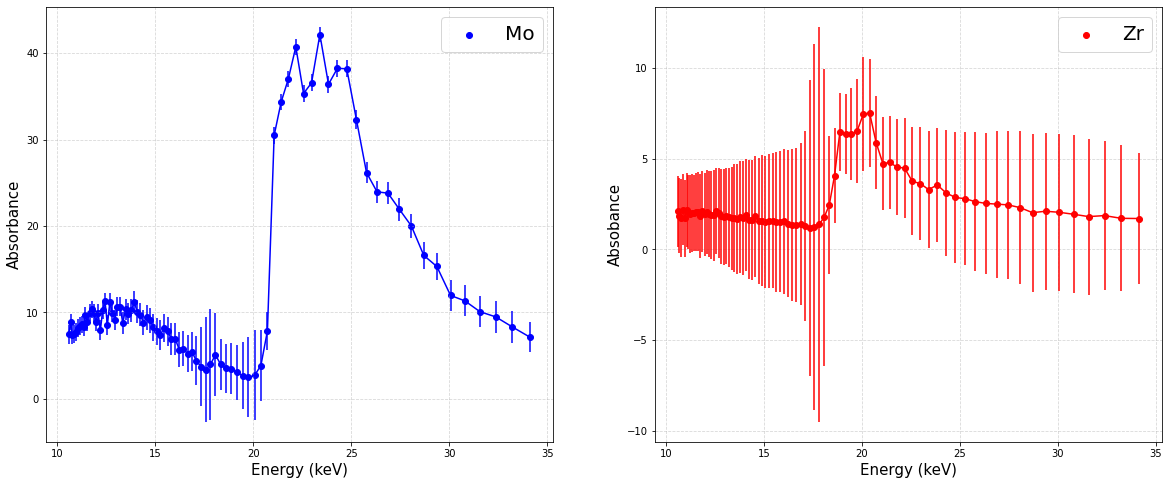

In [27]:
from numpy.core.fromnumeric import size
plt.figure(1, dpi=150)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax[0].scatter(df['Energy (keV)'],df['Mo Absorbance'], label='Mo', color='blue')
ax[0].errorbar(df['Energy (keV)'],df['Mo Absorbance'],yerr=df['Sigma Mo'],xerr=df['Sigma Energy (keV)'], color='blue', ecolor='blue')
ax[0].grid(ls='dashed', alpha=0.5)
ax[0].set_xlabel('Energy (keV)', fontsize=15)
ax[0].set_ylabel('Absorbance', fontsize=15)
ax[0].legend(fontsize=20)

ax[1].scatter(df['Energy (keV)'],df['Zr Absorbance'], label='Zr', color='red')
ax[1].errorbar(df['Energy (keV)'],df['Zr Absorbance'],yerr=df['Sigma Zr'],xerr=df['Sigma Energy (keV)'], color='red', ecolor='red')
ax[1].grid(ls='dashed', alpha=0.5)
ax[1].set_xlabel('Energy (keV)', fontsize=15)
ax[1].set_ylabel('Absobance', fontsize=15)
ax[1].legend(fontsize=20)

**Attenuation coefficient:**

From https://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html we can get the linear attenuation coefficients **μ**.

Now that we have the absorbance we can calculate the filter thickness, x, using the equation $A = e^{\mu x}$, where $A = \frac{N_o}{N}$ and the **μ**.

The NIST table returns us the mass attenuation coefficient μ/ρ (cm$^2$/g), where ρ is the density of the material. **μ** is the sum of every contribution from x-ray interaction with matter (coherent and incoherent scattering, photoelectric absorption). To obtain the **\mu** we must multiply the material density by μ/ρ. 

$ρ_{Mo}$ = 10.22 g/cm$^3$

$\rho_{Zr}$ = 6.52 g/cm$^3$

**From NIST table:**

**$\mu_{Mo}/ρ_{Mo}$:** 7.955E+1 cm$^2$/g (Total attenuation with coherent scattering)

**$\mu_{Zr}/ρ_{Zr}$:** 9.470E+1 cm$^2$/g (Total attenuation with coherent scattering)

So, the μ values are:

**$\mu_{Mo}$:** 813 cm$^{-1}$

**$μ_{Zr}$:** 617.44 cm$^{-1}$

**Calculating the thickness x:**

$A = e^{μx}$ $⇒$ $ln(A) = ln(e^{μx})$ $⇒$ $ln(A)=μx ln(e)$ $⇒$ $ln(A)=μx$

Then, $x = \frac{ln(A)}{μ}$.

**Plotting using plotly to find absorption edge:**

In [21]:
px.line(df, x='Energy (keV)',y='Zr Absorbance', error_y=df['Sigma Zr Absorb'], error_x=df['Sigma Energy (keV)'])

**Calculating filter thickness:**

In [14]:
A_Zr = 6.488  # Zr absorbance from the plot
A_Mo = 40.73494 # Mo absorbance from the plot


coef_Mo = 813 #cm^-1
coef_Zr = 617.44 #cm^-1

x_Mo = math.log(A_Mo)/coef_Mo # cm
x_Zr = math.log(A_Zr)/coef_Zr # cm

print('The thickness of Mo filter is:', x_Mo, 'cm', '\n', 'The thickness of Zr filter is:',x_Zr,'cm.')


The thickness of Mo filter is: 0.004559761624633085 cm 
 The thickness of Zr filter is: 0.0030285603731749025 cm.


**Calculating the percentage deviation of energy edges obtained in relation to the expected ones:**



In [25]:
E_Zr = 18.87472 # Zr edge energy from the plot (keV)
E_Mo = 22.1721 # Mo edge energy from the plot (keV)
E_s_Zr = 0.0005 # energy uncertainty (keV)
E_s_Mo = 0.0006 # energy uncertainty (keV)
E_t_Mo = 20.000 # Theoretical edge energy for Mo (keV)
E_t_Zr = 17.996 # Theoretical edge energy for Zr (keV)

dev_Mo = (abs(E_Mo - E_t_Mo)/(E_Mo))*100
dev_Zr = (abs(E_Zr - E_t_Zr)/(E_Zr))*100

print('The percentage deviation for Mo edge energy is', dev_Mo, 'and for Zr is', dev_Zr)

The percentage deviation for Mo edge energy is 9.796546109750544 and for Zr is 4.655539260979772
